In [1]:

import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch

/opt/anaconda3/envs/torch_base/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [41]:
def f(x):
  return 3*x**2 - 4*x + 5

In [42]:
f(3.0)

20.0

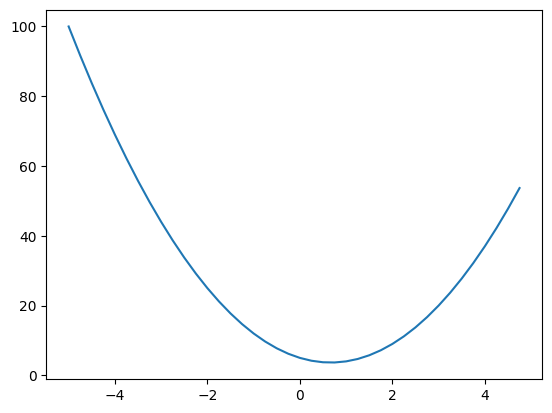

In [43]:

xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [44]:
from IPython import display
display.Image(url = 'https://wikimedia.org/api/rest_v1/media/math/render/svg/aae79a56cdcbc44af1612a50f06169b07f02cbf3')

In [45]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

In [46]:
# let's make it more complex
 
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [47]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [48]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad 
      other.grad += 1.0 * out.grad
    out._backward = _backward
    # the old version is  self.grad = 1.0 * out.grad. But If the same value is used twice in an equation grad values will overwrited
    # So in this bug grad values are not updated. We wanna calculate grad values cumulative way so new equation is self.grad += 1.0 * out.grad
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def backward(self): # automatized backward function
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [49]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

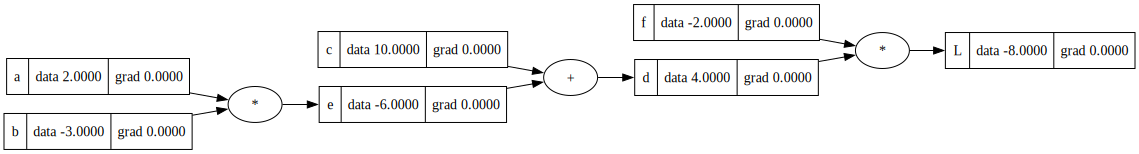

In [50]:
draw_dot(L)

In [51]:
def check_grad():
  
  h = 0.001
  
  # base
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data
  
  # control group
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  b.data += h
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data
  
  
  print((L2 - L1)/h)
  
# calculate grad for b

check_grad()

-3.9999999999995595


* The gradient value tells us how much and in which direction we should change the weight value.

In [52]:
# use check_grad function (also you can use derivative formul for being sure) for find and assign grad value to node
L.grad = 1
f.grad = 4
d.grad = -2
e.grad = -2
c.grad = -2
b.grad = -4
a.grad = 6

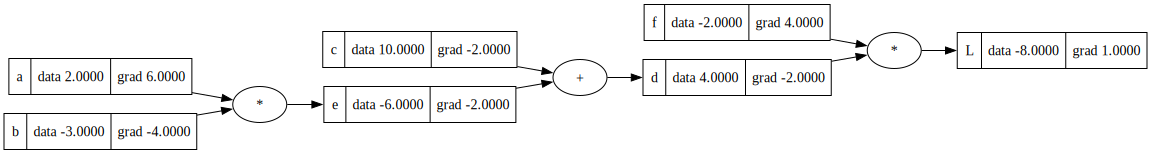

In [53]:
draw_dot(L)

* Calculate grad value for some nodes with manuel method
* * a = 2, b = -3, c=10, e = axb, d = e+c, f = -2, L = dxf
* * ...



In [54]:
a.data += 0.01 * a.grad # value update with 0.01 learning rate backforward
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b # forward pass
d = e + c
L = d * f

print(L.data)

-7.286496


# manuel backpropagation on neuron

In [55]:
from IPython import display
display.Image(url = 'https://cs231n.github.io/assets/nn1/neuron_model.jpeg')

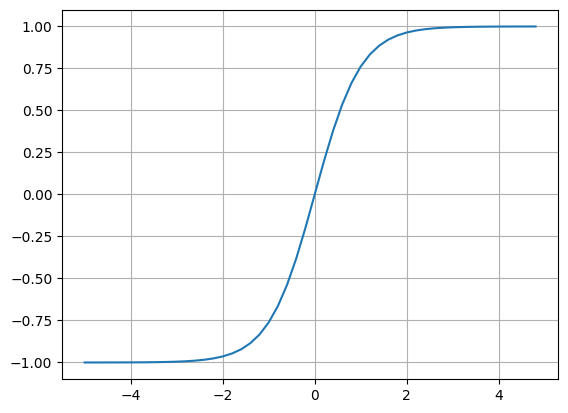

In [56]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid(); # tanh function

* we are using tanh function as a activation function because we need the differentiable function for getting derivative of output node at backpropagation step
* so activation function must be differentiable for model's learning

In [57]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'nn'
o = n.tanh(); o.label = 'output'

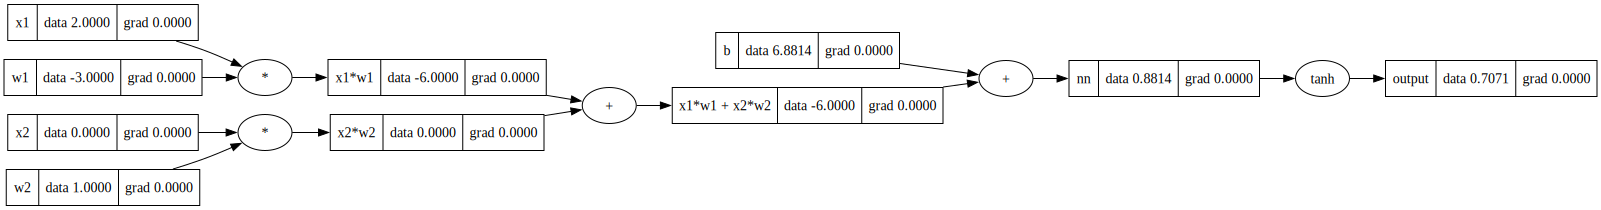

In [58]:
draw_dot(o)

In [59]:
o.grad = 1 # this is a default

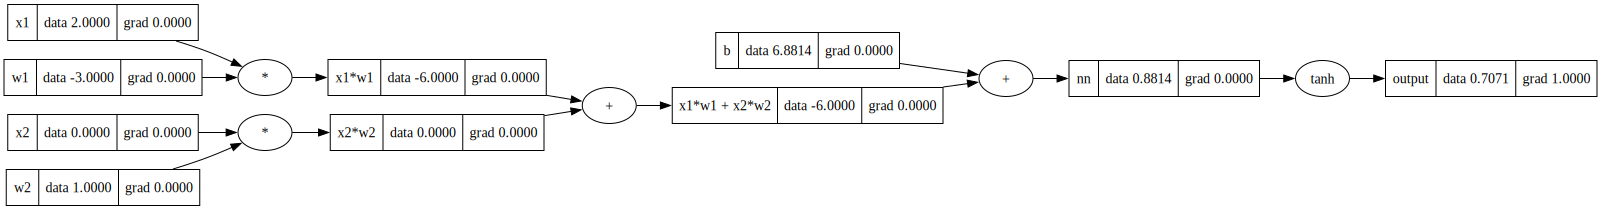

In [60]:
draw_dot(o)

In [61]:
from IPython import display
display.Image(url = 'https://wikimedia.org/api/rest_v1/media/math/render/svg/48e115d0848c424686f85f8d33cfe9f81c95cd58')

* so we can use tanh derivative 1-tanh**2(x)
* output = tanh(nn)
    ---> d(output)/ d(nn) = 1- tanh(nn)**2 ---> 1- o **2 


In [62]:
1 - o.data**2 # so this is a derivative of output it means grad of n

0.4999999999999999

In [63]:
n.grad = 0.5

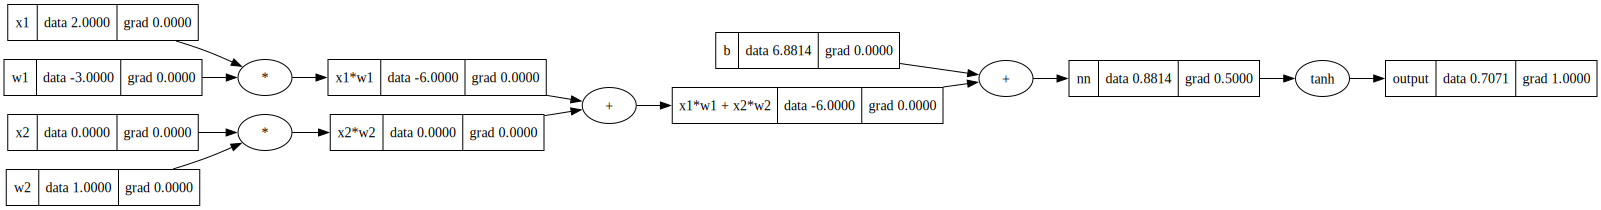

In [64]:
draw_dot(o)

*  plus is just a distributor of gradient so b and x1w1x2w2 nodes get the nn's gradient because of derivative rules

In [65]:
b.grad = n.grad
x1w1x2w2.grad = n.grad

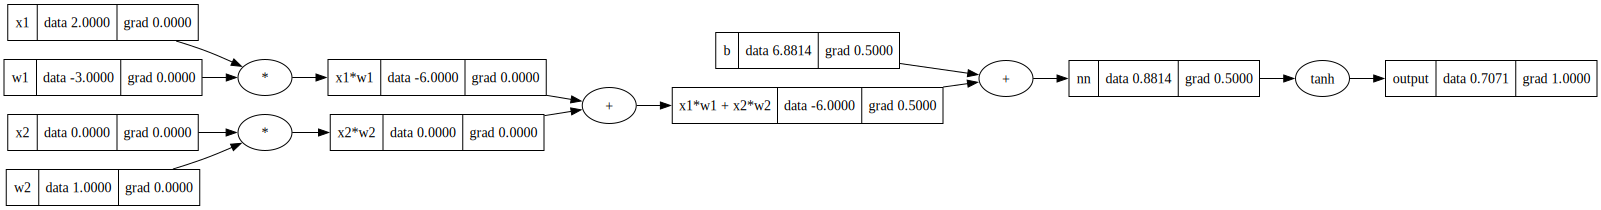

In [66]:
draw_dot(o)

* we have a another plus step so appling same rule

In [67]:
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

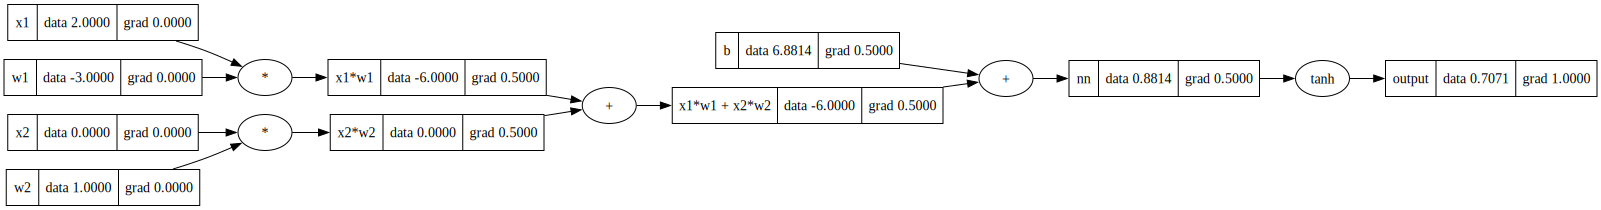

In [68]:
draw_dot(o)

* now we have a multiplication process x1 * w1 = x1w1
* in multiplication process we use the grad of result node on derivative
*   * x1w1  = x1 * w1  ---> d(x1w1) / d(x1) = w1 * x1w1.grad (for x1 derivative)
    * x1w1 = x1 * w1   ---> d(x1w1) / d(w1) = x1 * x1w1.grad (for w1 derivative)

In [69]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

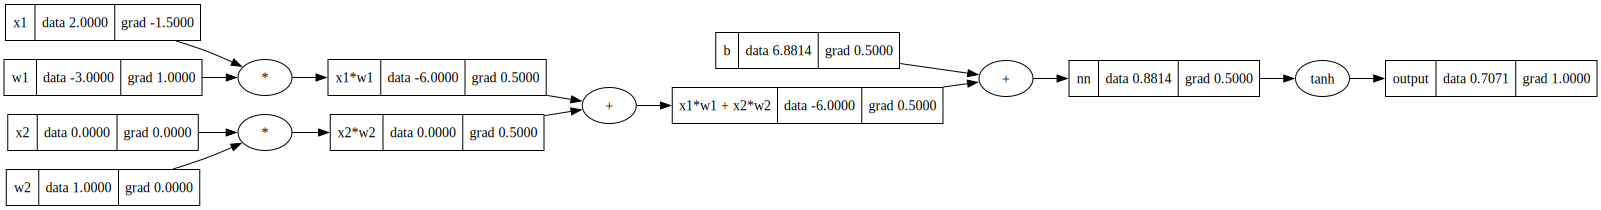

In [70]:
draw_dot(o)

* same situtiaon on x2w2 = x2 * w2
* in multiplication process we use the grad of result node on derivative
*   * x2w2  = x2 * w2  ---> d(x2w2) / d(x2) = w2 * x2w2.grad (for x2 derivative)
    * x2w2 = x2 * w2   ---> d(x2w2) / d(w2) = x2 * x2w2.grad (for w2 derivative)


In [71]:
w2.grad = x2.data * x2w2.grad
x2.grad = w2.data * x2w2.grad

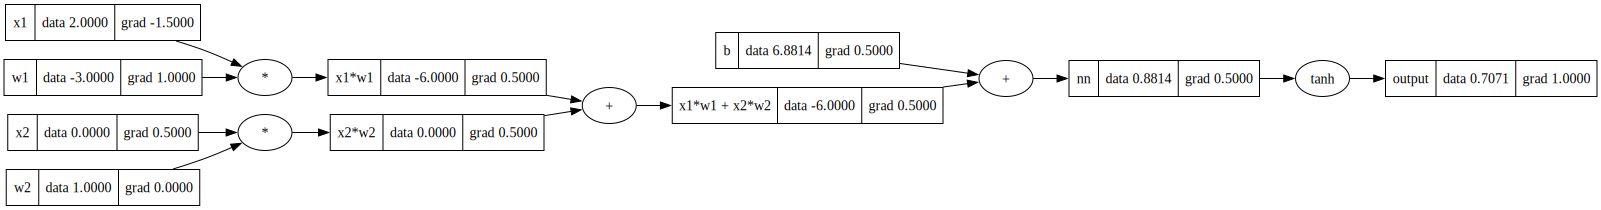

In [72]:
draw_dot(o)

# backpropagation with function

* we applied manuel backpropagation on above code, now we define the function in value  class  for doing automaticly (_backwards functions)
* now lets try with function

In [89]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'nn'
o = n.tanh(); o.label = 'output'

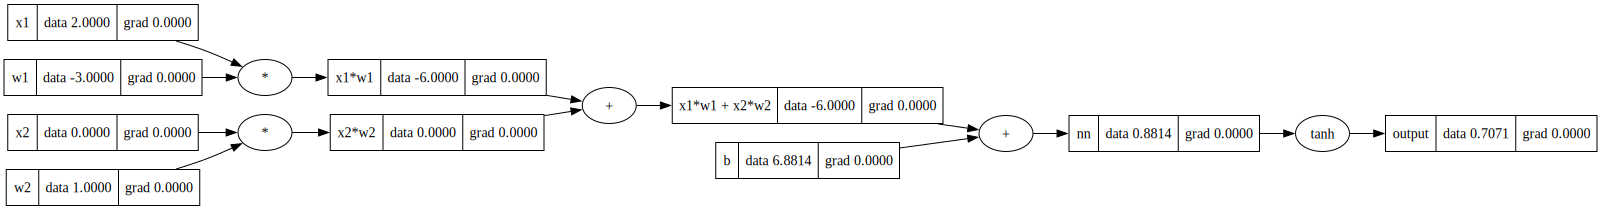

In [90]:
draw_dot(o)

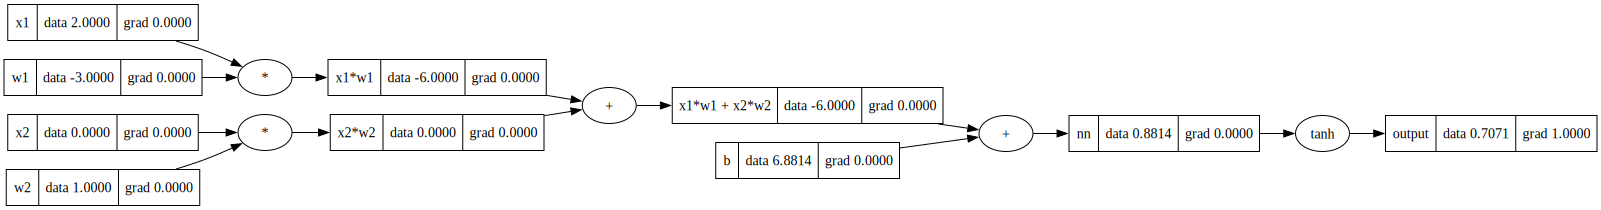

In [91]:
o.grad = 1 # default assign coming from derivative rule
draw_dot(o)

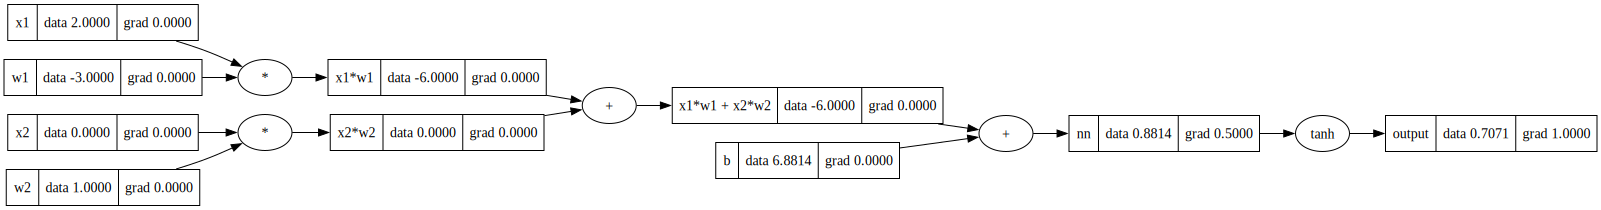

In [92]:
o._backward()
draw_dot(o)

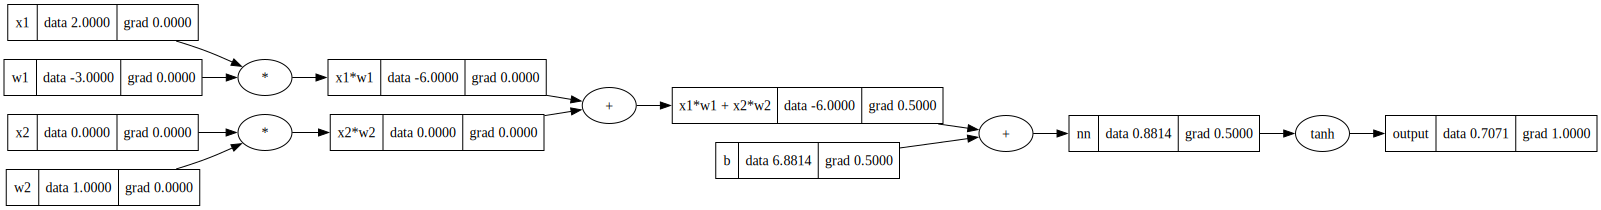

In [93]:
n._backward()
draw_dot(o)

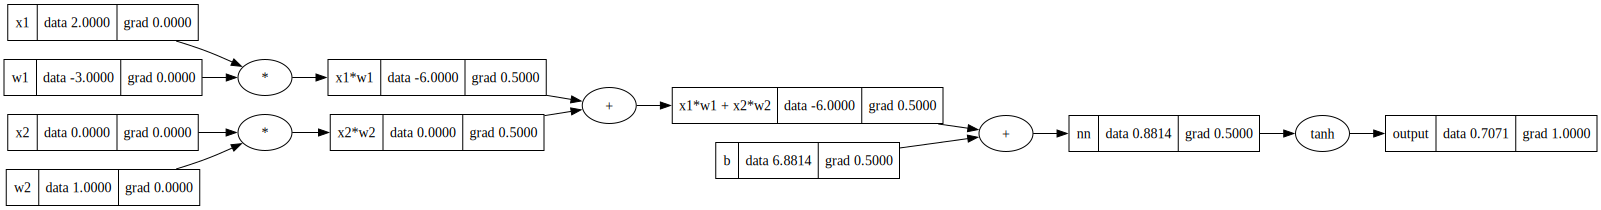

In [94]:
x1w1x2w2._backward()
draw_dot(o)

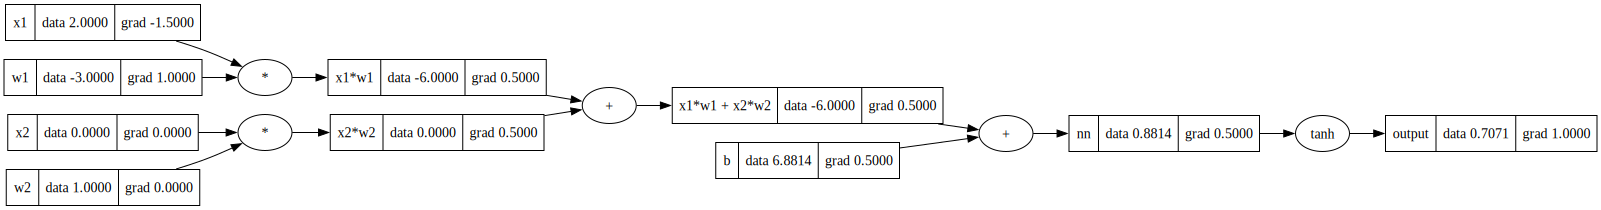

In [95]:
x1w1._backward()
draw_dot(o)

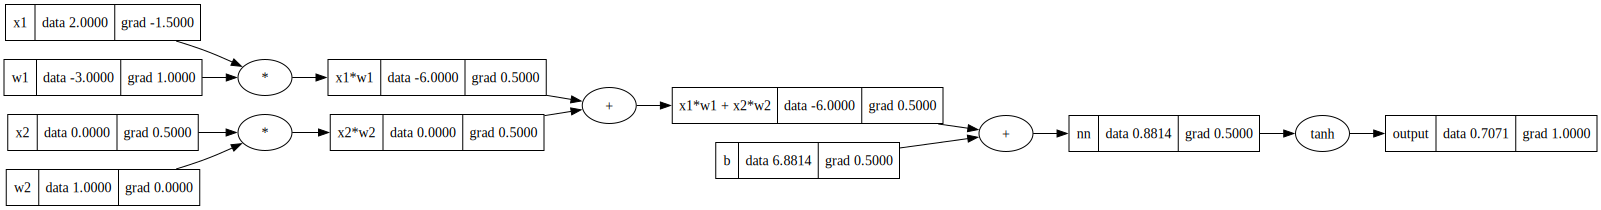

In [96]:
x2w2._backward()
draw_dot(o)

* Now We want to make a function that will do all the update operations. We need the topological sort because all nodes connected with each other
* First of all we need set grad values to 0 for observation

In [97]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'nn'
o = n.tanh(); o.label = 'output'

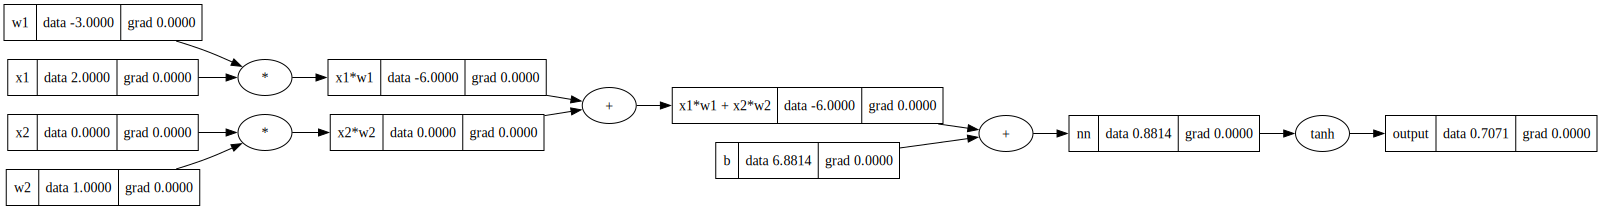

In [98]:
draw_dot(o)

In [99]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [100]:
o.grad = 1

topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)


for node in reversed(topo):
  node._backward()
# we are going to hiding this function to Value class

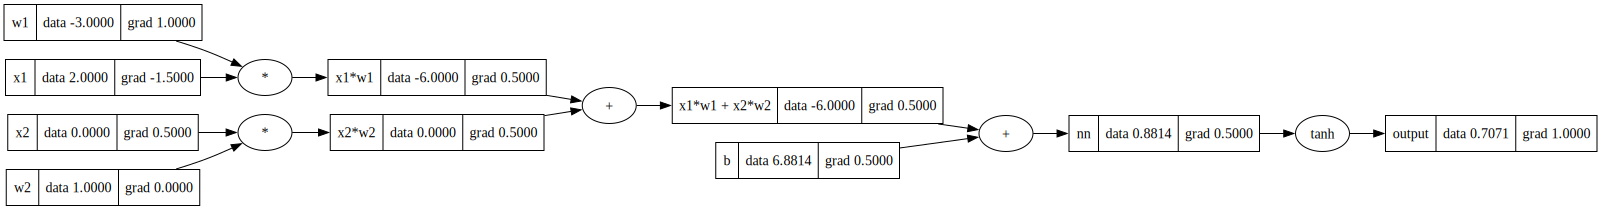

In [101]:
draw_dot(o)

* now we gonna use backward function that exist in Value class

In [102]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'nn'
o = n.tanh(); o.label = 'output'

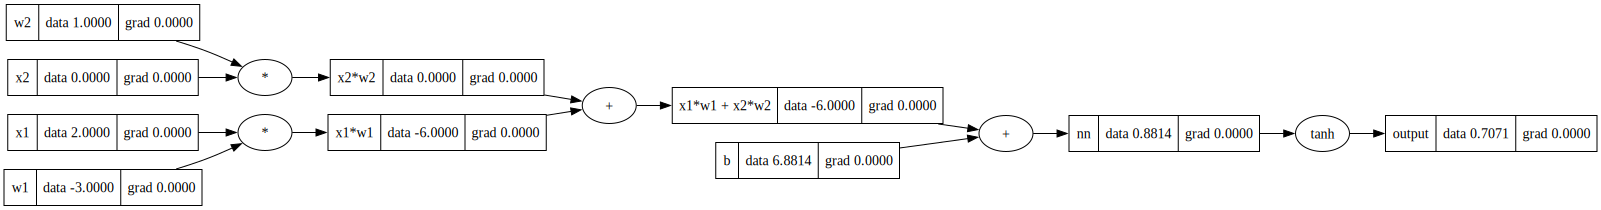

In [103]:
draw_dot(o)

In [104]:
o.backward()

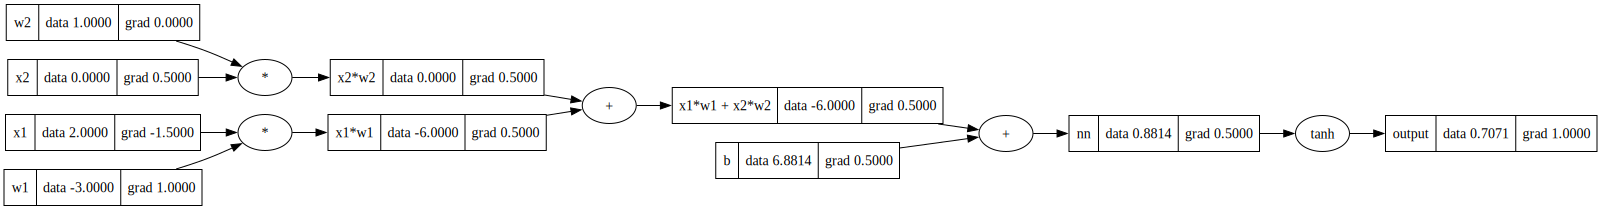

In [105]:
draw_dot(o)

* there was a bug in old version code lets check it out

In [108]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad = 1.0 * out.grad   # BUG IN HERE!!!!!
      other.grad = 1.0 * out.grad # BUG IN HERE!!!!!
    out._backward = _backward

    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def backward(self): # automatized backward function
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

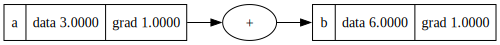

In [109]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

* When we used the same value on add operation we encountered this bug. Because the _backward() function in Value class its wrong
* self.grad = 1.0 * out.grad . In this case we are overwriting to grad value so it has been not  updated
* In this example node a's grad value should be 2 not 1.


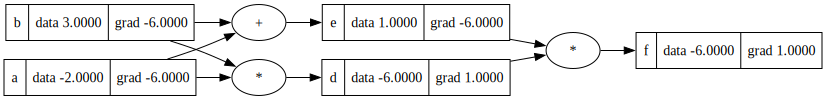

In [110]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

* Different version for this bug
* So we dont want overwrite to grad value. We want to cumulative update.

In [111]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad   # BUG FIXED!!!!!
      other.grad += 1.0 * out.grad #  BUG FIXED!!!!!
    out._backward = _backward

    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def backward(self): # automatized backward function
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

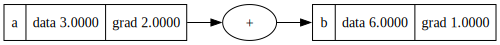

In [112]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

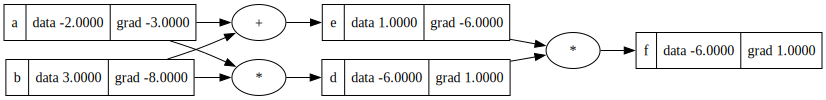

In [113]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

* Now bug fixed...

* In the example above, we used one of the derivative versions of the tanh function.
* now we use different derivative version of tanh function ant lets check result that we will find is equal old result? 
* First of all we have to update Value class for geting derivative different version of tanh


In [114]:
from IPython import display
display.Image(url = 'https://wikimedia.org/api/rest_v1/media/math/render/svg/3f2cf2340523c38532abdb7103962b9f990701d5')

In [115]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

 * Import notes  !!!

In [116]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [117]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

* with first version of tanh derivative

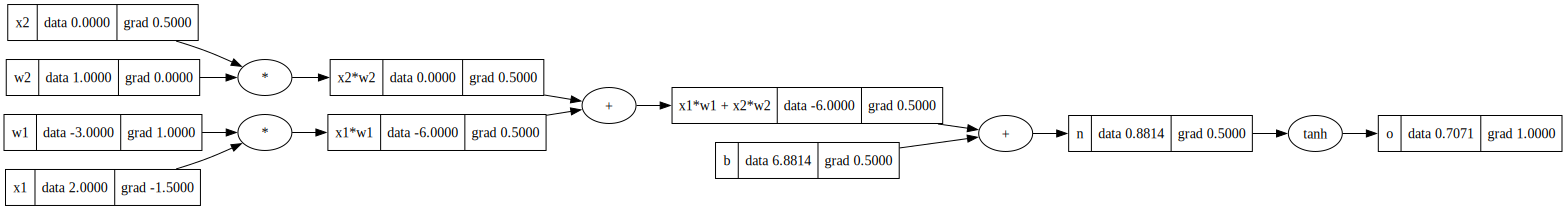

In [118]:
draw_dot(o)

* with 2. version of derivative tanh

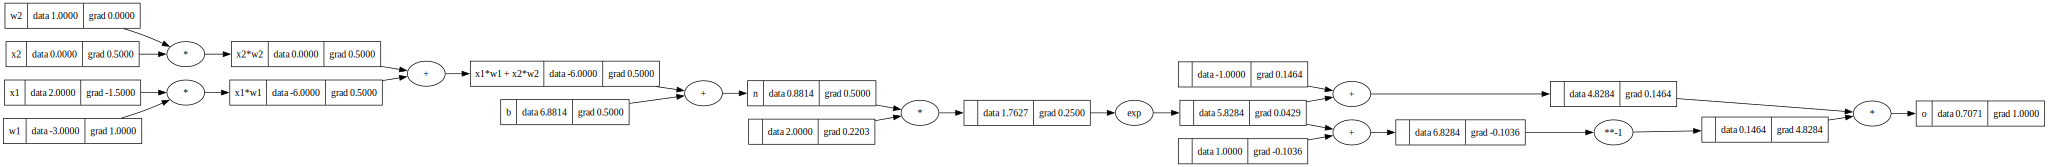

In [119]:

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

# torch part

In [120]:

import torch

In [121]:
torch.Tensor([2.0])

tensor([2.])

In [122]:
torch.Tensor([2.0]).dtype # default type

torch.float32

In [123]:
torch.Tensor([2.0]).double().dtype

torch.float64

* Let's do the apply we did create backpropagation manually above with pytroch.

In [124]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True 
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True 
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


* pytorch assumes they do not require gradients so we need to say that all of the these nodes require gradients

In [125]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [126]:
o.item()

0.7071066904050358

In [127]:
import random

In [128]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
  # w*x +b
    print(list(zip(self.w, x))) # for checkin
    act_func = sum((wi*xi for wi, xi in zip(self.w , x)),self.b) 
    out = act_func.tanh()
    return out

x = [2.0, 3.0]
n = Neuron(2)
n(x)
  

  
 
  

[(Value(data=-0.046866694857938374), 2.0), (Value(data=0.23886861866288922), 3.0)]


Value(data=0.8152284776392044)

* now we can forward single neuron
* now lets start define the layers of neuron

In [129]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
  # w*x +b
    #print(list(zip(self.w, x))) # for checkin
    act_func = sum((wi*xi for wi, xi in zip(self.w , x)),self.b) 
    out = act_func.tanh()
    return out

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
       outs = [n(x) for n in self.neurons]
       return outs

x = [2.0, 3.0] 
n = Layer(2,3) # 2 dimensional neuron 
n(x)

[Value(data=-0.987411872680848),
 Value(data=-0.4563171536850273),
 Value(data=0.04775378297854254)]

* lets build mlp version

In [130]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
  # w*x +b
    #print(list(zip(self.w, x))) # for checkin
    act_func = sum((wi*xi for wi, xi in zip(self.w , x)),self.b) 
    out = act_func.tanh()
    return out

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
       outs = [n(x) for n in self.neurons]
       return outs[0] if len(outs)==1 else outs
    

    
class MLP:
  def __init__(self, nin, nouts): # nouts = number of neuron on single layer, nin = number of inputs
    sz = [nin] + nouts # sz= size
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))] # create layer object
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x







x = [2.0, 3.0, -1.0] # input neuron's data
n = MLP(3, [4,4,1]) 
n(x)

Value(data=0.0793517052860693)

In [131]:
from IPython import display
display.Image(url = 'https://cs231n.github.io/assets/nn1/neural_net2.jpeg')

* This is the model we built in the code above

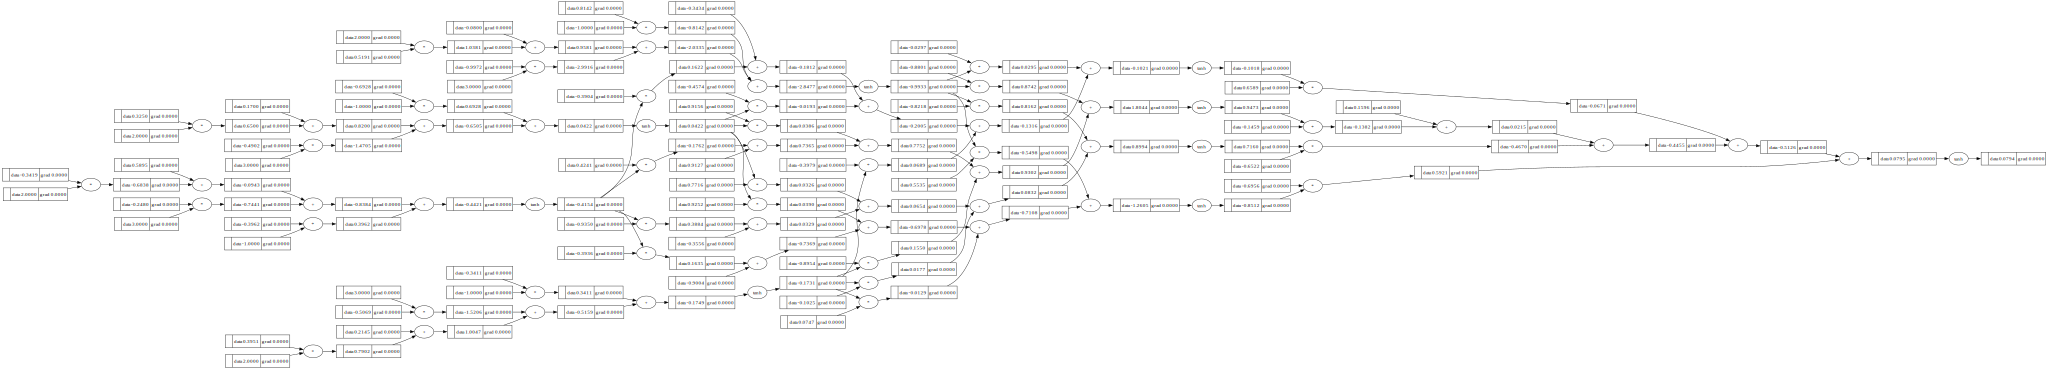

In [132]:
draw_dot(n(x))

* now we gonna apply backpropagation on dummy dataset

In [133]:

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred  = [n(x) for x in xs]
ypred

[Value(data=0.0793517052860693),
 Value(data=-0.5014641242939692),
 Value(data=0.8411275638947588),
 Value(data=-0.2070214388126714)]

* how do we make predict better, how do make tune the weight? Loss function....

In [134]:
[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)] # mean squared error

[Value(data=0.8475932825596686),
 Value(data=0.24853801936597894),
 Value(data=3.389750706533049),
 Value(data=1.4569007537534115)]

In [135]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])# mean squared error
loss

Value(data=5.942782762212109)

* In this case our goal is minimize the loss. Because if loss is low, every one of them predictions are equal to target

In [136]:
loss.backward()

In [137]:
n.layers[0].neurons[0].w[0].grad # check some of them neurons's grad

-0.11547764294464447

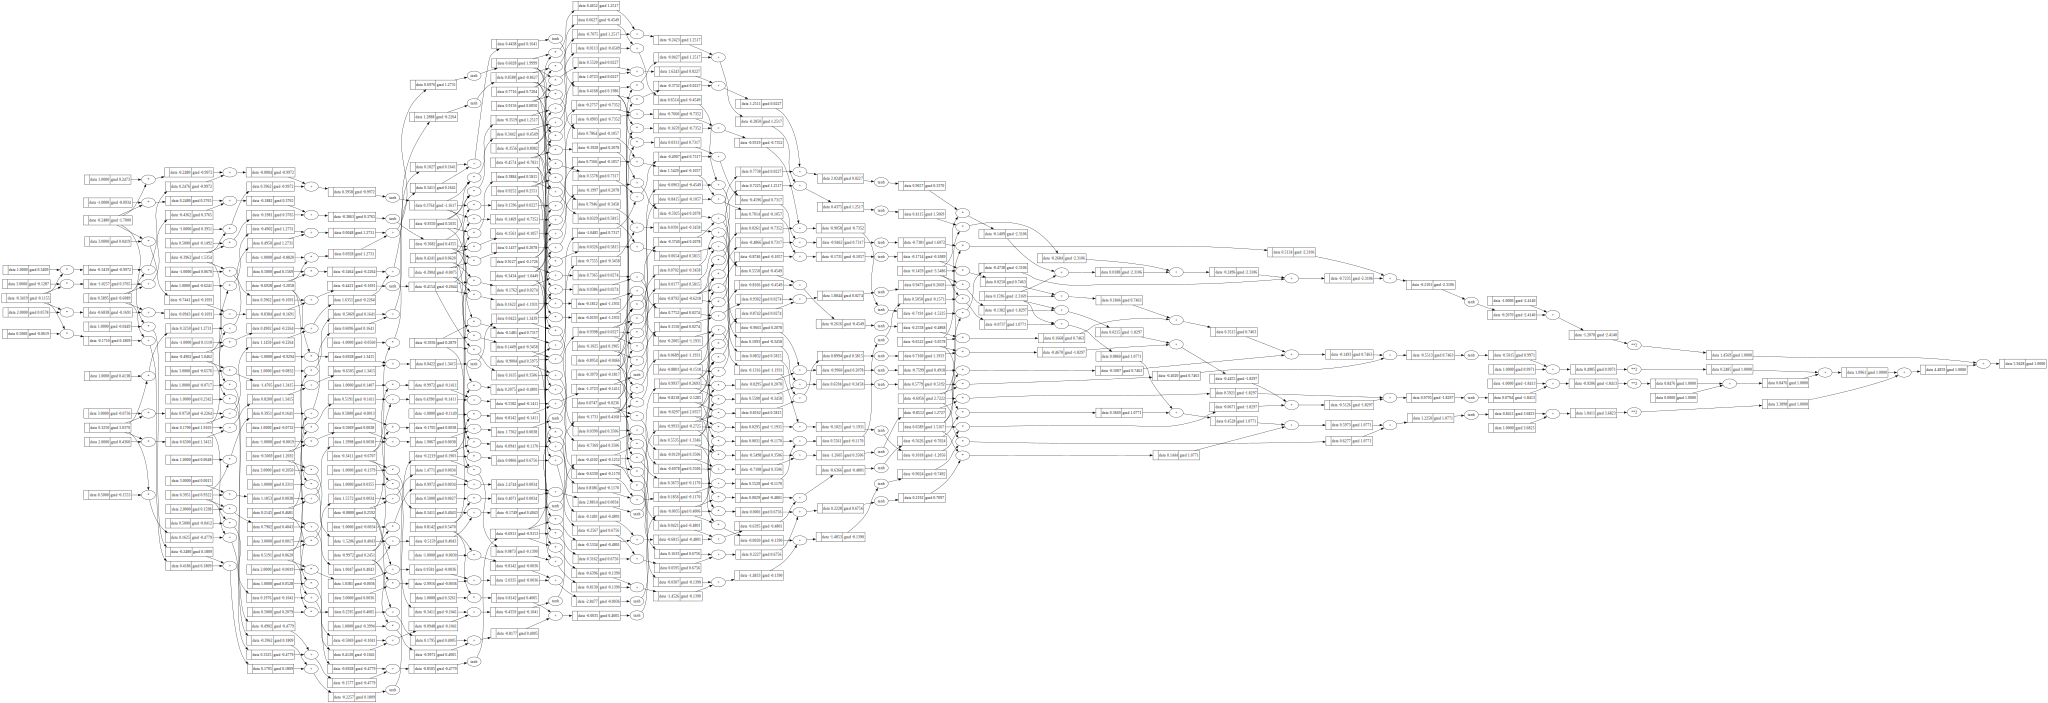

In [138]:
draw_dot(loss)

This output so complicated because its has a four forward pass for 4 inputs until calculate loss function. After that backpropagation starting to update grad .

In [139]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]
  


n = MLP(3, [4,4,1]) 


* now we added 'parameters' function for see nicely parameter

In [140]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred  = [n(x) for x in xs]
ypred

[Value(data=-0.11057612412984949),
 Value(data=0.6797442423280041),
 Value(data=-0.6272467793495738),
 Value(data=0.05859542448549237)]

* this time output was different from the last one because our weight initialize random...

In [141]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=5.080107585426276)

* our first loss value is 5.080107585426276

In [142]:
n.layers[0].neurons[0].w[0].data 

-0.30921134670540007

In [143]:
n.layers[0].neurons[0].w[0].grad # grad is 0 because backpropagation doesnt start yet

0.0

In [144]:
loss.backward()

In [145]:
n.layers[0].neurons[0].w[0].data 

-0.30921134670540007

In [146]:
n.layers[0].neurons[0].w[0].grad 

-0.213875635570823

In [147]:
for p in n.parameters():
    p.data += -0.01 * p.grad # we want to decrease the loss value, so  use learning rate(-0.01) negative.

In [148]:
n.layers[0].neurons[0].w[0].data 

-0.30707259034969187

* This is to minimize the loss function value by operating in learning rate using gradient values ​​on a single neuron value.
* Lets check loss fucntion with updated data

In [149]:
ypred= [n(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=4.34035897312631)

* 4.34035897312631(updated loss) < 5.080107585426276(first loss)
* We reduce the loss value !

* When we continuously run the above processes manually, we can observe that the data value in the neurons changes and approaches the desired value.
* But if you increase the learning rate for get a result faster, in some point you may not get update anymore. This is a trade-off. 

* If LR is too low you gonna take way too long to converge but if its too high all thing gets unstable and your loss value may be explode
* So because of that LR is a hyperparameter


* Now all we have to do is we have to iterate this process

In [150]:
n = MLP(3, [4,4,1]) 
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred  = [n(x) for x in xs]
ypred

[Value(data=-0.169579953775117),
 Value(data=0.29490375103098004),
 Value(data=0.31307123631648226),
 Value(data=-0.1031291184001698)]

In [151]:
# Gradient DEscent
for step in range(20):
    # forward pass
    ypred= [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
    
    # backward pass
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(step, loss.data)


0 5.985742916210738
1 0.8000308341308722
2 2.8530267752878546
3 0.02196193386198473
4 3.322170926222485
5 3.8631026820610708
6 3.9827773777783655
7 3.980873976739889
8 3.9184295311812574
9 3.7165134808659857
10 0.06635773046004266
11 7.683098386909323e-06
12 8.886844693160157e-06
13 1.11031136497086e-05
14 1.3878090545736993e-05
15 1.7176793606474095e-05
16 2.098207968799775e-05
17 2.5306481273434223e-05
18 3.019494787755542e-05
19 3.572235646397865e-05


* We can observe the decrease of the loss value

In [152]:
ypred

[Value(data=0.9957752416813367),
 Value(data=-0.9999999998854011),
 Value(data=-0.999999997444609),
 Value(data=0.9957722614067498)]

* BUT THERE IS A BUG ! ... 
* When after backpropagation we dont flush the grad. So when we do the second forward pass and backward again these grads just add up never get reset to zero
* *        for p in n.parameters():
                p.data += -0.05 * p.grad # wrong part
* When we have a this bug and gets a good result because our data is so basic so bug has been not effect us . If when we have a more complex problem this bug may being root cause of not optimize the loss  
* Lets fix

In [153]:
n = MLP(3, [4,4,1]) 

In [154]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] 


In [155]:
# Gradient DEscent
for step in range(20):
    # forward pass
    ypred= [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
    
    # backward pass
    for p in n.parameters():
        p.grad = 0.0 # now we set grads to zero before backward 
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(step, loss.data)


0 4.440878510024353
1 3.3692469413801005
2 2.446933823365879
3 1.6653064949732732
4 1.09192077446518
5 0.7331419207285479
6 0.5242103503892893
7 0.39788113373767064
8 0.31626441167037367
9 0.26023822840350774
10 0.21983188477735569
11 0.18951924919454882
12 0.1660477852050532
13 0.1473995524371718
14 0.13226515152731988
15 0.1197620267349316
16 0.10927576439591578
17 0.10036659597108533
18 0.09271211950593375
19 0.08607098839837773


In [156]:
ypred

[Value(data=0.8747853299877679),
 Value(data=-0.8693283854812582),
 Value(data=-0.8474768906110214),
 Value(data=0.8266393785385834)]

# The END